# Evaluation of all trained retrieval models on test dataset of NFCorpus 

In [1]:
import torch
import math
import random
from transformers import AutoTokenizer, AutoModel
import numpy as np
import regex as re
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import torch.utils.checkpoint as checkpoint
from collections import defaultdict
from ir_evaluation.effectiveness import effectiveness
import faiss
import pandas as pd
import json
import pytrec_eval
import matplotlib.pyplot as plt 

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-11-08 11:19:36.746516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 11:19:36.953895: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Read corpus
df_corpus = pd.read_json('nfcorpus/corpus.jsonl', lines=True)
df_corpus

,_id,title,text,metadata
0,MED-10,Statin Use and Breast Cancer Survival: A Natio...,"Recent studies have suggested that statins, an...",{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/25...
1,MED-14,Statin use after diagnosis of breast cancer an...,BACKGROUND: Preclinical studies have shown tha...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/25...
2,MED-118,Alkylphenols in human milk and their relations...,The aims of this study were to determine the c...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/20...
3,MED-301,Methylmercury: A Potential Environmental Risk ...,Epilepsy or seizure disorder is one of the mos...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/22...
4,MED-306,Sensitivity of Continuous Performance Test (CP...,Hit Reaction Time latencies (HRT) in the Conti...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/20...
...,...,...,...,...
3628,MED-917,Effect of freezing and storage on the phenolic...,Scottish-grown red raspberries are a rich sour...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/12...
3629,MED-941,Topical vitamin A treatment of recalcitrant co...,BACKGROUND: Common warts (verruca vulgaris) ar...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed?te...
3630,MED-942,Esophageal injury by apple cider vinegar table...,Apple cider vinegar products are advertised in...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/15...
3631,MED-952,Cannabis and the lung.,The use of cannabis is embedded within many so...,{'url': 'http://www.ncbi.nlm.nih.gov/pubmed/21...


In [7]:
doc_id_to_idx = {}
for idx, row in df_corpus.iterrows():
    doc_id = row['_id']
    doc_id_to_idx[doc_id] = idx

In [8]:
# Read corpus
df_queries = pd.read_json('nfcorpus/queries.jsonl', lines=True)
df_queries

,_id,text,metadata
0,PLAIN-3,Breast Cancer Cells Feed on Cholesterol,{'url': 'http://nutritionfacts.org/2015/07/14/...
1,PLAIN-4,Using Diet to Treat Asthma and Eczema,{'url': 'http://nutritionfacts.org/2015/07/09/...
2,PLAIN-5,Treating Asthma With Plants vs. Pills,{'url': 'http://nutritionfacts.org/2015/07/07/...
3,PLAIN-6,How Fruits and Vegetables Can Treat Asthma,{'url': 'http://nutritionfacts.org/2015/07/02/...
4,PLAIN-7,How Fruits and Vegetables Can Prevent Asthma,{'url': 'http://nutritionfacts.org/2015/06/30/...
...,...,...,...
3232,PLAIN-3432,Healthy Chocolate Milkshakes,{'url': 'http://nutritionfacts.org/video/healt...
3233,PLAIN-3442,The Healthiest Vegetables,{'url': 'http://nutritionfacts.org/video/the-h...
3234,PLAIN-3452,Bowel Movement Frequency,{'url': 'http://nutritionfacts.org/video/bowel...
3235,PLAIN-3462,Olive Oil and Artery Function,{'url': 'http://nutritionfacts.org/video/olive...


In [9]:
query_id_to_idx = {}
for idx, row in df_queries.iterrows():
    query_id = row['_id']
    query_id_to_idx[query_id] = idx

In [10]:
# Read qrels
path = f'nfcorpus/qrels/test.tsv'
df_test = pd.read_csv(path, sep='\t')
df_test

,query-id,corpus-id,score
0,PLAIN-2,MED-2427,2
1,PLAIN-2,MED-10,2
2,PLAIN-2,MED-2429,2
3,PLAIN-2,MED-2430,2
4,PLAIN-2,MED-2431,2
...,...,...,...
12329,PLAIN-3472,MED-3623,1
12330,PLAIN-3472,MED-3624,1
12331,PLAIN-3472,MED-3625,1
12332,PLAIN-3472,MED-3626,1


In [11]:
queries = []
query_ids = []
st = set()
for _, row in df_test.iterrows():
    query_id = row['query-id']
    if query_id not in st:
        idx = query_id_to_idx[query_id]
        query_ids.append(query_id)
        queries.append(df_queries.iloc[idx]['text'])
        st.add(query_id)

In [12]:
print(query_ids[:5])

['PLAIN-2', 'PLAIN-12', 'PLAIN-23', 'PLAIN-33', 'PLAIN-44']


In [13]:
print(queries[:5])

['Do Cholesterol Statin Drugs Cause Breast Cancer?', 'Exploiting Autophagy to Live Longer', 'How to Reduce Exposure to Alkylphenols Through Your Diet', 'What’s Driving America’s Obesity Problem?', 'Who Should be Careful About Curcumin?']


In [14]:
class RetrieverModelBertBased(nn.Module):
    '''
    Model architecture class for retrieval models containing an encoder whose inner working is similar to BERT
    '''
    def __init__(self, encoder_name, encoder_output_dim=768):
        super(RetrieverModelBertBased, self).__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.encoder_output_dim = encoder_output_dim
        self.projection_output_dim = 128
        self.query_projection_layer = nn.Linear(self.encoder_output_dim, self.projection_output_dim, bias=False)
        self.doc_projection_layer = nn.Linear(self.encoder_output_dim, self.projection_output_dim, bias=False)
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction="mean")

    def encode(self, input_ids, attention_mask, checkpoint_batch_size):
        if checkpoint_batch_size == None or input_ids.shape[0] < checkpoint_batch_size:
            return self.encoder(input_ids, attention_mask)['pooler_output']

        device = input_ids.device
        input_shape = input_ids.size()
        token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)
        head_mask = [None] * self.encoder.config.num_hidden_layers
        extended_attention_mask: torch.Tensor = self.encoder.get_extended_attention_mask(
            attention_mask, input_shape, device
        )

        def partial_encode(*inputs):
            encoder_outputs = self.encoder.encoder(inputs[0], attention_mask=inputs[1], head_mask=head_mask,)
            sequence_output = encoder_outputs[0]
            pooled_output = self.encoder.pooler(sequence_output)
            return pooled_output

        embedding_output = self.encoder.embeddings(
            input_ids=input_ids, position_ids=None, token_type_ids=token_type_ids, inputs_embeds=None
        )

        pooled_output_list = []
        for b in range(math.ceil(input_ids.shape[0] / checkpoint_batch_size)):
            b_embedding_output = embedding_output[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
            b_attention_mask = extended_attention_mask[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
            pooled_output = checkpoint.checkpoint(partial_encode, b_embedding_output, b_attention_mask)
            pooled_output_list.append(pooled_output)
        return torch.cat(pooled_output_list, dim=0)

    def project_queries(self, query_ids, query_mask, checkpoint_batch_size):
        query_encoding = self.encode(query_ids, query_mask, checkpoint_batch_size)
        query_projection = self.query_projection_layer(query_encoding)
        return query_projection

    def project_docs(self, doc_ids, doc_mask, checkpoint_batch_size):
        doc_encoding = self.encode(doc_ids, doc_mask, checkpoint_batch_size)
        doc_projection = self.doc_projection_layer(doc_encoding)
        return doc_projection

    def forward(self, query_ids, query_mask, doc_ids, doc_mask, checkpoint_batch_size):
        query_projection = self.project_queries(query_ids, query_mask, checkpoint_batch_size)
        doc_projection = self.project_docs(doc_ids, doc_mask, checkpoint_batch_size)
        dot_product_scores = torch.mm(query_projection, doc_projection.t())

        batch_size = dot_product_scores.shape[0]
        labels = torch.arange(batch_size).to(device)
        loss1 = self.cross_entropy_loss(dot_product_scores, labels)
        loss2 = self.cross_entropy_loss(dot_product_scores.t(), labels)
        return (loss1+loss2)/2

In [15]:
# Retriever model for distillbert based encoder
class RetrieverModelDistillBertBased(nn.Module):
    '''
    Model architecture class for retrieval models containing an encoder whose inner working is similar to DistilBERT
    '''
    def __init__(self, encoder_name, encoder_output_dim=768):
        super(RetrieverModelDistillBertBased, self).__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.encoder_output_dim = encoder_output_dim
        self.projection_output_dim = 128
        self.query_projection_layer = nn.Linear(self.encoder_output_dim, self.projection_output_dim, bias=False)
        self.doc_projection_layer = nn.Linear(self.encoder_output_dim, self.projection_output_dim, bias=False)
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction="mean")

    def mean_pooling(self, sequence_output, attn_mask):
        input_mask_expanded = attn_mask.unsqueeze(-1).expand(sequence_output.size()).float()
        return torch.sum(sequence_output * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def encode(self, input_ids, attention_mask, checkpoint_batch_size):
        if checkpoint_batch_size == None or input_ids.shape[0] < checkpoint_batch_size:
            encoder_outputs = self.encoder(input_ids, attention_mask)
            sequence_output = encoder_outputs[0]
            pooled_output = self.mean_pooling(sequence_output, attention_mask)
            return pooled_output

        device = input_ids.device
        head_mask = [None] * self.encoder.config.num_hidden_layers

        def partial_encode(*inputs):
            encoder_outputs = self.encoder.transformer(inputs[0], attn_mask=inputs[1], head_mask=head_mask,)
            sequence_output = encoder_outputs[0]
            pooled_output = self.mean_pooling(sequence_output, attn_mask=inputs[1])
            return pooled_output

        embedding_output = self.encoder.embeddings(
            input_ids=input_ids
        )

        pooled_output_list = []
        for b in range(math.ceil(input_ids.shape[0] / checkpoint_batch_size)):
            b_embedding_output = embedding_output[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
            b_attention_mask = attention_mask[b * checkpoint_batch_size : (b + 1) * checkpoint_batch_size]
            pooled_output = checkpoint.checkpoint(partial_encode, b_embedding_output, b_attention_mask)
            pooled_output_list.append(pooled_output)
        return torch.cat(pooled_output_list, dim=0)

    def project_queries(self, query_ids, query_mask, checkpoint_batch_size):
        query_encoding = self.encode(query_ids, query_mask, checkpoint_batch_size)
        query_projection = self.query_projection_layer(query_encoding)
        return query_projection

    def project_docs(self, doc_ids, doc_mask, checkpoint_batch_size):
        doc_encoding = self.encode(doc_ids, doc_mask, checkpoint_batch_size)
        doc_projection = self.doc_projection_layer(doc_encoding)
        return doc_projection

    def forward(self, query_ids, query_mask, doc_ids, doc_mask, checkpoint_batch_size):
        query_projection = self.project_queries(query_ids, query_mask, checkpoint_batch_size)
        doc_projection = self.project_docs(doc_ids, doc_mask, checkpoint_batch_size)
        dot_product_scores = torch.mm(query_projection, doc_projection.t())

        batch_size = dot_product_scores.shape[0]
        labels = torch.arange(batch_size).to(device)
        loss1 = self.cross_entropy_loss(dot_product_scores, labels)
        loss2 = self.cross_entropy_loss(dot_product_scores.t(), labels)
        return (loss1+loss2)/2

In [16]:
# Utility Functions

def get_query_projections(queries, retriever_model, tokenizer, device='cuda:0'):
    '''
    Compute the query projection vectors for a list of queries using the given retrieval model
    '''
    
    tokenized_queries = tokenizer(queries, max_length = 32, padding='max_length', truncation = True)
    query_ids = torch.LongTensor(tokenized_queries["input_ids"]).to(device)
    query_mask = torch.LongTensor(tokenized_queries["attention_mask"]).to(device)
    
    with torch.no_grad():
        query_projections = retriever_model.project_queries(query_ids, query_mask, checkpoint_batch_size=None).cpu().type(torch.float)
    return query_projections.numpy()

def get_doc_projections(docs, retriever_model, tokenizer, device='cuda:0'):
    '''
    Compute the document projection vectors for a list of queries using the given retrieval model
    '''
    
    tokenized_docs = tokenizer(docs, max_length = 256, padding='max_length', truncation = True)
    doc_ids = torch.LongTensor(tokenized_docs["input_ids"]).to(device)
    doc_mask = torch.LongTensor(tokenized_docs["attention_mask"]).to(device)
    
    with torch.no_grad():
        doc_projections = retriever_model.project_docs(doc_ids, doc_mask, checkpoint_batch_size=None).cpu().type(torch.float)
    return doc_projections.numpy()

def create_doc_memmap(docs, filename, retriever_model, tokenizer, device='cuda:0'):
    '''
    Convert document vectors to numopy memmap
    '''
    
    memmap = np.memmap(filename, dtype='float32', mode='w+', shape=(len(docs), 128))
    num_batches = math.ceil(len(docs)/batch_size)

    for i in tqdm(range(num_batches), ncols=80):
        batch = docs[i*batch_size : (i+1)*batch_size]
        memmap[i*batch_size : (i+1)*batch_size] = get_doc_projections(batch, retriever_model, tokenizer, device)

def create_faiss_index_from_memmap(filename, num_samples, device):
    '''
    Create FAISS index
    '''
    
    memmap = np.memmap(filename, dtype='float32', mode='r', shape=(num_samples, 128))

    gpu_resources = faiss.StandardGpuResources()
    index = faiss.IndexFlatIP(128)
    index = faiss.index_cpu_to_gpu(gpu_resources, device, index)
    index.add(memmap)
    return index

def evaluate(query_ids, ranking=None, scores=None, k_vals=[5,10,20], results_file=None):
    '''
    Evaluation using pytrec_eval
    '''
    
    path = f'nfcorpus/qrels/test.tsv'
    df = pd.read_csv(path, sep='\t')
    
    qrels = defaultdict(dict)
    for _, row in df.iterrows():
        query_id, doc_id, score = row['query-id'], row['corpus-id'], row['score']
        qrels[query_id][doc_id] = score
    
    results = defaultdict(dict)
    
    if results_file is None:
        for i in range(len(ranking)):
            query_id = query_ids[i]
            for j in range(len(ranking[i])):
                doc_id = df_corpus.iloc[ranking[i][j]]['_id']
                score = float(scores[i][j])
                results[query_id][doc_id] = score
    else:
        with open(results_file, 'r') as f:
            content = f.read()
            results = json.loads(content)
            
    ndcg = {}
    _map = {}
    recall = {}
    precision = {}

    for k in k_vals:
        ndcg[f"NDCG@{k}"] = 0.0
        _map[f"MAP@{k}"] = 0.0
        recall[f"Recall@{k}"] = 0.0
        precision[f"P@{k}"] = 0.0

    map_string = "map_cut." + ",".join([str(k) for k in k_vals])
    ndcg_string = "ndcg_cut." + ",".join([str(k) for k in k_vals])
    recall_string = "recall." + ",".join([str(k) for k in k_vals])
    precision_string = "P." + ",".join([str(k) for k in k_vals])
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, {map_string, ndcg_string, recall_string, precision_string})
    scores = evaluator.evaluate(results)
    
    for query_id in scores.keys():
        for k in k_vals:
            ndcg[f"NDCG@{k}"] += scores[query_id]["ndcg_cut_" + str(k)]
            _map[f"MAP@{k}"] += scores[query_id]["map_cut_" + str(k)]
            recall[f"Recall@{k}"] += scores[query_id]["recall_" + str(k)]
            precision[f"P@{k}"] += scores[query_id]["P_"+ str(k)]

    for k in k_vals:
        ndcg[f"NDCG@{k}"] = round(ndcg[f"NDCG@{k}"]/len(scores), 5)
        _map[f"MAP@{k}"] = round(_map[f"MAP@{k}"]/len(scores), 5)
        recall[f"Recall@{k}"] = round(recall[f"Recall@{k}"]/len(scores), 5)
        precision[f"P@{k}"] = round(precision[f"P@{k}"]/len(scores), 5)
        
    return ndcg, _map, recall, precision
    

def query_index(queries, num_docs, faiss_index, retriever_model, tokenizer, device='cuda:0'):
    '''
    Query FAISS index for given queries
    Returns the ranking and dot product scores for top 'num_docs' documents for all queries
    '''
    
    num_batches = math.ceil(len(queries)/batch_size)
    ranking = []
    scores = []

    for i in tqdm(range(num_batches), ncols=80):
        batch = queries[i*batch_size : (i+1)*batch_size]
        q_projections = get_query_projections(batch, retriever_model, tokenizer, device)
        D, I = faiss_index.search(q_projections, num_docs)
        ranking.append(I)
        scores.append(D)

    ranking = np.array(ranking)
    scores = np.array(scores)
    ranking = np.concatenate(ranking, axis=0)
    scores = np.concatenate(scores, axis=0)

    return ranking, scores

In [17]:
def load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='bert-based', device='cuda:0'):
    '''
    Loads retrieval model with specified training weights along with its tokenizer
    '''
    
    tokenizer = AutoTokenizer.from_pretrained(encoder_model_name)
    
    if variant == 'bert-based':
        retriever_model = RetrieverModelBertBased(encoder_model_name)
    elif variant == 'distillbert-based':
        retriever_model = RetrieverModelDistillBertBased(encoder_model_name)
    elif variant == 'minilm-based':
        retriever_model = RetrieverModelBertBased(encoder_model_name, encoder_output_dim=384)
    elif variant == 'xlm-roberta-based':
        retriever_model = RetrieverModelBertBased(encoder_model_name, encoder_output_dim=1024)
    
    retriever_model.to(device)
    saved_checkpoint = torch.load(root_dir + retriever_model_name, map_location=device)
    retriever_model.load_state_dict(saved_checkpoint['model'])
    return tokenizer, retriever_model

In [18]:
def iap(ranking):
    '''
    Compute the 11 point IAP (Interpolated Average Precision) metric for a given ranking of a model
    '''
    
    interactions ={}
    qry_ids = list(df_test['query-id'].unique())
    for qid in qry_ids:
        if interactions.get(qid) is None:
            interactions[qid] = {}
        if interactions[qid].get('related_documents') is None:
            interactions[qid]['related_documents'] = set()
        for doc_id in list(df_test[df_test['query-id']==qid]['corpus-id']):
            interactions[qid]['related_documents'].add(doc_id)
    for i in range(len(ranking)):
        qid = query_ids[i]
        interactions[qid]['total_result'] = len(ranking[i])
        for j in range(len(ranking[i])):
            indx = ranking[i][j]
            did = df_corpus.iloc[indx,0]
            if did in interactions[qid]['related_documents']:
                if interactions[qid].get('visited_documents') is None:
                    interactions[qid]['visited_documents'] = []
                interactions[qid]['visited_documents'].append(did)
                if interactions[qid].get('visited_documents_orders') is None:
                    interactions[qid]['visited_documents_orders'] = {}
                interactions[qid]['visited_documents_orders'][did] = j+1 
    for qry_id in interactions:
        if interactions[qry_id].get('total_result') is None:
            interactions[qry_id]['total_result'] =  '0'
        if interactions[qry_id].get('visited_documents') is None:
            interactions[qry_id]['visited_documents'] = []
        if interactions[qry_id].get('visited_documents_orders') is None:
            interactions[qry_id]['visited_documents_orders'] = {}
    ir = effectiveness()
    result = ir.iap(interactions)
    return result

## Evaluation of retriever_multi-qa-distilbert-dot-v1_bs_1024_epoch_10

In [15]:
batch_size = 1024
device = 'cuda:1'
root_dir = './models/'
num_passages=1000

In [16]:
retriever_model_name = 'retriever_multi-qa-distilbert-dot-v1_bs_1024_epoch_10.pth'
encoder_model_name = 'sentence-transformers/multi-qa-distilbert-dot-v1'
index_name = f'{retriever_model_name[:-4]}_passage_index.dat'

In [17]:
tokenizer, retriever_model = load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='distillbert-based', device=device)

In [18]:
create_doc_memmap(list(df_corpus['text']), index_name, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]


In [19]:
faiss_index = create_faiss_index_from_memmap(index_name, num_samples=len(df_corpus), device=int(device[-1]))

In [20]:
ranking, scores = query_index(queries, num_passages, faiss_index, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.37it/s]


In [21]:
metrics = evaluate(query_ids, ranking, scores, k_vals=[5,10,20,50,100,500,1000])

In [22]:
metrics

({'NDCG@5': 0.33017,
  'NDCG@10': 0.32893,
  'NDCG@20': 0.33253,
  'NDCG@50': 0.34582,
  'NDCG@100': 0.36988,
  'NDCG@500': 0.43887,
  'NDCG@1000': 0.47174},
 {'MAP@5': 0.0904,
  'MAP@10': 0.12131,
  'MAP@20': 0.15568,
  'MAP@50': 0.19172,
  'MAP@100': 0.20948,
  'MAP@500': 0.2326,
  'MAP@1000': 0.23751},
 {'Recall@5': 0.11079,
  'Recall@10': 0.16581,
  'Recall@20': 0.24496,
  'Recall@50': 0.36649,
  'Recall@100': 0.4586,
  'Recall@500': 0.69507,
  'Recall@1000': 0.80468},
 {'P@5': 0.31703,
  'P@10': 0.28142,
  'P@20': 0.2404,
  'P@50': 0.16978,
  'P@100': 0.12043,
  'P@500': 0.04619,
  'P@1000': 0.02866})

In [23]:
iap1 = iap(ranking)
iap1

{'0.0': 0.4837795272839093,
 '0.1': 0.41037159479907975,
 '0.2': 0.35671182366462534,
 '0.3': 0.31209975559095027,
 '0.4': 0.27255100780988106,
 '0.5': 0.2479158296126182,
 '0.6': 0.2001149433726388,
 '0.7': 0.16374598218850836,
 '0.8': 0.13939672137988016,
 '0.9': 0.10648139172006706,
 '1.0': 0.08026027689382095}

## Evaluation of retriever_distil-biobert_bs_1024_epoch_10.pth

In [24]:
batch_size = 1024
device = 'cuda:1'
root_dir = './models/'
num_passages=1000

In [25]:
retriever_model_name = 'retriever_distil-biobert_bs_1024_epoch_10.pth'
encoder_model_name = 'nlpie/distil-biobert'
index_name = f'{retriever_model_name[:-4]}_passage_index.dat'

In [26]:
tokenizer, retriever_model = load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='bert-based', device=device)

Some weights of the model checkpoint at nlpie/distil-biobert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at nlpie/distil-biobert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
Y

In [27]:
create_doc_memmap(list(df_corpus['text']), index_name, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.21s/it]


In [28]:
faiss_index = create_faiss_index_from_memmap(index_name, num_samples=len(df_corpus), device=int(device[-1]))

In [29]:
ranking, scores = query_index(queries, num_passages, faiss_index, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.37it/s]


In [30]:
metrics = evaluate(query_ids, ranking, scores, k_vals=[5,10,20,50,100,500,1000])

In [31]:
metrics

({'NDCG@5': 0.31242,
  'NDCG@10': 0.30883,
  'NDCG@20': 0.31789,
  'NDCG@50': 0.33668,
  'NDCG@100': 0.35906,
  'NDCG@500': 0.42453,
  'NDCG@1000': 0.45922},
 {'MAP@5': 0.0969,
  'MAP@10': 0.12483,
  'MAP@20': 0.15704,
  'MAP@50': 0.19388,
  'MAP@100': 0.21111,
  'MAP@500': 0.23175,
  'MAP@1000': 0.23695},
 {'Recall@5': 0.11014,
  'Recall@10': 0.15392,
  'Recall@20': 0.22897,
  'Recall@50': 0.3584,
  'Recall@100': 0.44752,
  'Recall@500': 0.6707,
  'Recall@1000': 0.7853},
 {'P@5': 0.2935,
  'P@10': 0.26006,
  'P@20': 0.22647,
  'P@50': 0.16743,
  'P@100': 0.11749,
  'P@500': 0.04388,
  'P@1000': 0.02804})

In [32]:
iap2 = iap(ranking)
iap2

{'0.0': 0.44736269117406535,
 '0.1': 0.3896811532388718,
 '0.2': 0.35103237506423984,
 '0.3': 0.3090454390043405,
 '0.4': 0.2717227062210693,
 '0.5': 0.24423132940765624,
 '0.6': 0.20825251301498934,
 '0.7': 0.1746679241799304,
 '0.8': 0.1485829092128042,
 '0.9': 0.11715889181839026,
 '1.0': 0.09734645442223297}

## Evaluation of retriever_multi-qa-MiniLM-L6-dot-v1_epochwise_bs_1024_epoch_10.pth

In [17]:
batch_size = 1024
device = 'cuda:1'
root_dir = './models/'
num_passages=1000

In [18]:
retriever_model_name = 'retriever_multi-qa-MiniLM-L6-dot-v1_epochwise_bs_1024_epoch_10.pth'
encoder_model_name = 'sentence-transformers/multi-qa-MiniLM-L6-dot-v1'
index_name = f'{retriever_model_name[:-4]}_passage_index.dat'

In [19]:
tokenizer, retriever_model = load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='minilm-based', device=device)

In [20]:
create_doc_memmap(list(df_corpus['text']), index_name, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


In [21]:
faiss_index = create_faiss_index_from_memmap(index_name, num_samples=len(df_corpus), device=int(device[-1]))

In [22]:
ranking, scores = query_index(queries, num_passages, faiss_index, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.19it/s]


In [23]:
metrics = evaluate(query_ids, ranking, scores, k_vals=[5,10,20,50,100,500,1000])

In [31]:
metrics

({'NDCG@5': 0.29648,
  'NDCG@10': 0.29445,
  'NDCG@20': 0.29102,
  'NDCG@50': 0.29697,
  'NDCG@100': 0.31832,
  'NDCG@500': 0.38948,
  'NDCG@1000': 0.42654},
 {'MAP@5': 0.07678,
  'MAP@10': 0.10609,
  'MAP@20': 0.13347,
  'MAP@50': 0.15878,
  'MAP@100': 0.17424,
  'MAP@500': 0.19402,
  'MAP@1000': 0.19909},
 {'Recall@5': 0.09478,
  'Recall@10': 0.14986,
  'Recall@20': 0.20916,
  'Recall@50': 0.29903,
  'Recall@100': 0.38163,
  'Recall@500': 0.6164,
  'Recall@1000': 0.73972},
 {'P@5': 0.28483,
  'P@10': 0.25356,
  'P@20': 0.20728,
  'P@50': 0.14396,
  'P@100': 0.10387,
  'P@500': 0.04171,
  'P@1000': 0.02709})

## Evaluation of retriever_UMLSBert_ENG_bs_1024_epoch_10.pth (BEST model)

In [106]:
batch_size = 512
device = 'cuda:1'
root_dir = './models/'
num_passages=1000

In [107]:
retriever_model_name = 'retriever_UMLSBert_ENG_bs_1024_epoch_7.pth'
encoder_model_name = 'GanjinZero/UMLSBert_ENG'
index_name = f'{retriever_model_name[:-4]}_passage_index.dat'

In [108]:
tokenizer, retriever_model = load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='bert-based', device=device)

In [109]:
create_doc_memmap(list(df_corpus['text']), index_name, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 8/8 [00:16<00:00,  2.06s/it]


In [110]:
faiss_index = create_faiss_index_from_memmap(index_name, num_samples=len(df_corpus), device=int(device[-1]))

In [111]:
ranking, scores = query_index(queries, num_passages, faiss_index, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


In [112]:
metrics = evaluate(query_ids, ranking, scores, k_vals=[5,10,20,50,100,500,1000])

In [61]:
# 10th epoch
metrics

({'NDCG@5': 0.37474,
  'NDCG@10': 0.37147,
  'NDCG@20': 0.37808,
  'NDCG@50': 0.39158,
  'NDCG@100': 0.41183,
  'NDCG@500': 0.4773,
  'NDCG@1000': 0.50959},
 {'MAP@5': 0.12289,
  'MAP@10': 0.15755,
  'MAP@20': 0.19407,
  'MAP@50': 0.23296,
  'MAP@100': 0.25176,
  'MAP@500': 0.275,
  'MAP@1000': 0.2799},
 {'Recall@5': 0.13601,
  'Recall@10': 0.19633,
  'Recall@20': 0.28129,
  'Recall@50': 0.4016,
  'Recall@100': 0.49026,
  'Recall@500': 0.71508,
  'Recall@1000': 0.82356},
 {'P@5': 0.34489,
  'P@10': 0.30062,
  'P@20': 0.25511,
  'P@50': 0.18099,
  'P@100': 0.12622,
  'P@500': 0.04692,
  'P@1000': 0.02908})

In [69]:
# 7th epoch (Best Results)
metrics

({'NDCG@5': 0.38951,
  'NDCG@10': 0.38266,
  'NDCG@20': 0.37841,
  'NDCG@50': 0.3823,
  'NDCG@100': 0.40276,
  'NDCG@500': 0.47018,
  'NDCG@1000': 0.50132},
 {'MAP@5': 0.12297,
  'MAP@10': 0.15671,
  'MAP@20': 0.19267,
  'MAP@50': 0.22617,
  'MAP@100': 0.24376,
  'MAP@500': 0.26639,
  'MAP@1000': 0.27124},
 {'Recall@5': 0.13916,
  'Recall@10': 0.19411,
  'Recall@20': 0.27018,
  'Recall@50': 0.38089,
  'Recall@100': 0.46811,
  'Recall@500': 0.70567,
  'Recall@1000': 0.80496},
 {'P@5': 0.35851,
  'P@10': 0.3096,
  'P@20': 0.25248,
  'P@50': 0.17214,
  'P@100': 0.1208,
  'P@500': 0.04534,
  'P@1000': 0.02827})

In [44]:
# 3rd epoch
metrics

({'NDCG@5': 0.38444,
  'NDCG@10': 0.37897,
  'NDCG@20': 0.37628,
  'NDCG@50': 0.37389,
  'NDCG@100': 0.39193,
  'NDCG@500': 0.45882,
  'NDCG@1000': 0.49416},
 {'MAP@5': 0.11868,
  'MAP@10': 0.15489,
  'MAP@20': 0.18953,
  'MAP@50': 0.21985,
  'MAP@100': 0.23532,
  'MAP@500': 0.25697,
  'MAP@1000': 0.26195},
 {'Recall@5': 0.13461,
  'Recall@10': 0.19534,
  'Recall@20': 0.26154,
  'Recall@50': 0.35975,
  'Recall@100': 0.44656,
  'Recall@500': 0.67362,
  'Recall@1000': 0.79565},
 {'P@5': 0.36099,
  'P@10': 0.31084,
  'P@20': 0.2548,
  'P@50': 0.16638,
  'P@100': 0.11446,
  'P@500': 0.04426,
  'P@1000': 0.02797})

In [45]:
iap3 = iap(ranking)
iap3

{'0.0': 0.5380178877546796,
 '0.1': 0.45455656307410736,
 '0.2': 0.39173274187378615,
 '0.3': 0.33212432837276423,
 '0.4': 0.28886362296895546,
 '0.5': 0.2573548852440013,
 '0.6': 0.2126954727068552,
 '0.7': 0.18066990282859782,
 '0.8': 0.15788043334344898,
 '0.9': 0.12468779305342352,
 '1.0': 0.10153776460841234}

## Evaluation of retriever_BiomedNLP-KRISSBERT-PubMed-UMLS-EL_bs_1024_epoch_10.pth

In [66]:
batch_size = 512
device = 'cuda:1'
root_dir = './models/'
num_passages=1000

In [67]:
retriever_model_name = 'retriever_BiomedNLP-KRISSBERT-PubMed-UMLS-EL_bs_1024_epoch_10.pth'
encoder_model_name = 'microsoft/BiomedNLP-KRISSBERT-PubMed-UMLS-EL'
index_name = f'{retriever_model_name[:-4]}_passage_index.dat'

In [68]:
tokenizer, retriever_model = load_retriever_model(root_dir, retriever_model_name, encoder_model_name, variant='bert-based', device=device)

In [69]:
create_doc_memmap(list(df_corpus['text']), index_name, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 8/8 [00:16<00:00,  2.06s/it]


In [70]:
faiss_index = create_faiss_index_from_memmap(index_name, num_samples=len(df_corpus), device=int(device[-1]))

In [71]:
ranking, scores = query_index(queries, num_passages, faiss_index, retriever_model, tokenizer, device)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


In [72]:
metrics = evaluate(query_ids, ranking, scores, k_vals=[5,10,20,50,100,500,1000])

In [73]:
# 10th epoch
metrics

({'NDCG@5': 0.3635,
  'NDCG@10': 0.3581,
  'NDCG@20': 0.36511,
  'NDCG@50': 0.37143,
  'NDCG@100': 0.39351,
  'NDCG@500': 0.46166,
  'NDCG@1000': 0.49472},
 {'MAP@5': 0.11552,
  'MAP@10': 0.1492,
  'MAP@20': 0.18717,
  'MAP@50': 0.22518,
  'MAP@100': 0.24399,
  'MAP@500': 0.26619,
  'MAP@1000': 0.27111},
 {'Recall@5': 0.13175,
  'Recall@10': 0.1795,
  'Recall@20': 0.25806,
  'Recall@50': 0.36758,
  'Recall@100': 0.46159,
  'Recall@500': 0.70347,
  'Recall@1000': 0.81359},
 {'P@5': 0.34613,
  'P@10': 0.29969,
  'P@20': 0.25867,
  'P@50': 0.17715,
  'P@100': 0.12421,
  'P@500': 0.04588,
  'P@1000': 0.0287})

## Interpolated Average Precision Plot for selected models

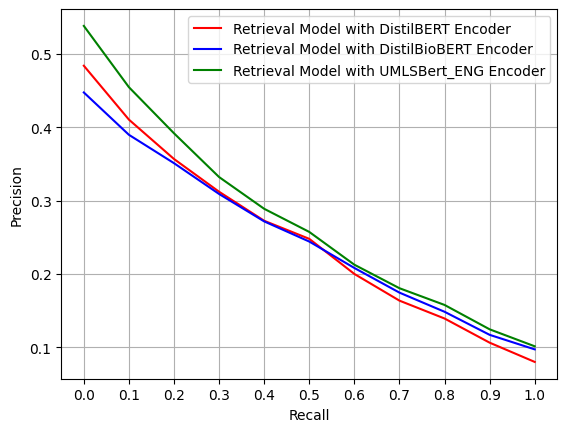

In [54]:
x1 = list(iap1.keys())
x2 = list(iap2.keys())
x3 = list(iap3.keys())
y1 = list(iap1.values())
y2 = list(iap2.values())
y3 = list(iap3.values())
plt.plot(x1, y1, 'r',label='Retrieval Model with DistilBERT Encoder')
plt.plot(x2, y2, 'b',label='Retrieval Model with DistilBioBERT Encoder') 
plt.plot(x3, y3, 'g',label='Retrieval Model with UMLSBert_ENG Encoder')
plt.legend()
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('iap.jpg')
plt.show()

In [ ]:
# END